# Importation des bibiothèques nécessaires

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, measure
from sklearn.metrics import jaccard_score, f1_score
import time

In [21]:
# Charger l'image
image_path = r'C:\Users\Admin\Desktop\School\S5\Computer vision\TP_Contours\contour.jpg'
image = cv2.imread(image_path)

# Méthode 1 : Adaptative thresholding

## From scratch

In [83]:
def adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Appliquer le seuillage adaptatif
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    return thresh

In [ ]:
adaptive_threshold(image)

array([[255, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [255,   0,   0, ..., 255, 255,   0],
       [255,   0,   0, ..., 255, 255,   0],
       [255,   0,   0, ..., 255, 255,   0]], dtype=uint8)

# Méthode 2 : Seuillage Adaptatif (Otsu)

## From Scratch

In [77]:
def otsu_thresholding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

In [6]:
otsu_thresholding(image)

array([[255, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ..., 255,   0, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255,   0,   0, ..., 255, 255,   0],
       [255,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0]], dtype=uint8)

# Résultat du Seuillage Otsu et d'adaptative thresholding

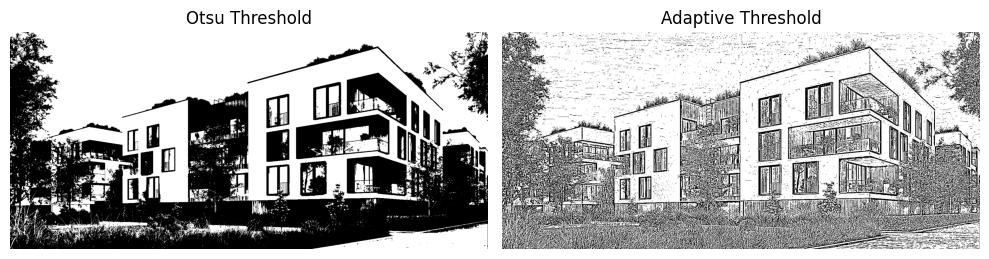

In [95]:
# Convertir l'image en niveaux de gris
image=cv2.imread(r'contour.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer le seuillage Otsu
_, otsu_threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Appliquer le seuillage adaptatif
adaptive_threshold = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)

# Afficher les résultats dans le notebook
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Otsu Threshold')
plt.imshow(otsu_threshold, cmap='gray')
plt.axis('off')  # Désactiver les axes

plt.subplot(1, 2, 2)
plt.title('Adaptive Threshold')
plt.imshow(adaptive_threshold, cmap='gray')
plt.axis('off')  # Désactiver les axes

plt.tight_layout()
plt.show()

## Mesure des performances

In [96]:
def performance_metrics(prediction, ground_truth):
    # Assurez-vous que les images sont binaires (0 ou 1)
    prediction = prediction.astype(np.uint8)
    ground_truth = ground_truth.astype(np.uint8)

    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)

    # Calculer IoU et Dice
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    dice = 2 * np.sum(intersection) / (np.sum(prediction) + np.sum(ground_truth)) if (np.sum(prediction) + np.sum(ground_truth)) != 0 else 0

    return iou, dice

In [97]:
ground_truth = cv2.imread(r'masked_image.jpg', cv2.IMREAD_GRAYSCALE)
_, ground_truth_binary = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)  # Assurez-vous que c'est binaire
# Appliquer les métriques de performance
iou_otsu, dice_otsu = performance_metrics(otsu_threshold > 0, ground_truth_binary > 0)
iou_adaptive, dice_adaptive = performance_metrics(adaptive_threshold > 0, ground_truth_binary > 0)

# Afficher les résultats des métriques
print(f"Otsu - IoU: {iou_otsu:.4f}, Dice: {dice_otsu:.4f}")
print(f"Adaptive - IoU: {iou_adaptive:.4f}, Dice: {dice_adaptive:.4f}")

Otsu - IoU: 0.0350, Dice: 0.0676
Adaptive - IoU: 0.0415, Dice: 0.0796


# Méthode 3 : Croissance de Régions

## Version from scratch

In [78]:
def region_growing(image, seed_point, threshold=5):
    seed_x, seed_y = seed_point
    # Create a mask to keep track of the region
    region_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    region_mask[seed_x, seed_y] = 255

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    region_mean = gray[seed_x, seed_y]

    # Use a list as a queue for pixels to explore
    pixels_to_explore = [(seed_x, seed_y)]

    while pixels_to_explore:
        x, y = pixels_to_explore.pop(0)

        # Check the neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                nx, ny = x + dx, y + dy
                # Check bounds
                if 0 <= nx < gray.shape[0] and 0 <= ny < gray.shape[1]:
                    if region_mask[nx, ny] == 0:  # Not yet in the region
                        if abs(int(gray[nx, ny]) - region_mean) < threshold:
                            region_mask[nx, ny] = 255
                            region_mean = (region_mean + gray[nx, ny]) / 2
                            pixels_to_explore.append((nx, ny))  # Add to explore list

    return region_mask

In [17]:
image_path = (r'1.jpeg')
image = cv2.imread(image_path)

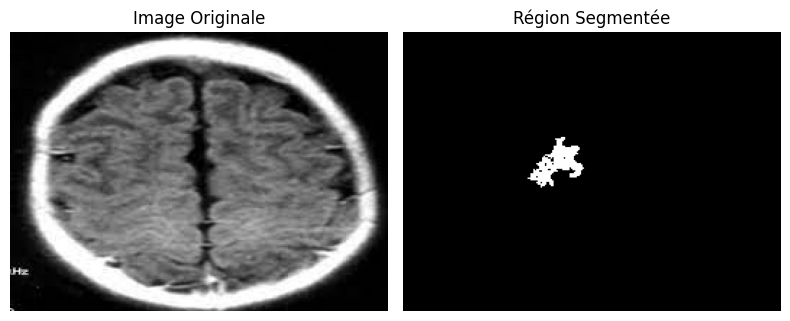

In [18]:
# Vérifier si l'image a été chargée correctement
if image is None:
    print(f"Erreur : l'image à '{image_path}' n'a pas pu être chargée. Vérifiez le chemin.")
else:
    # Définir le point de départ (graine)
    seed_point = (100, 100)  # Changez ceci selon votre image
        
    # Appliquer la croissance des régions
    segmented_image = region_growing(image, seed_point)

    # Afficher le masque de la région dans le notebook
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.title('Image Originale')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR à RGB pour l'affichage
    plt.axis('off')  # Désactiver les axes

    plt.subplot(1, 2, 2)
    plt.title('Région Segmentée')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')  # Désactiver les axes

    plt.tight_layout()
    plt.show()

## Version importée

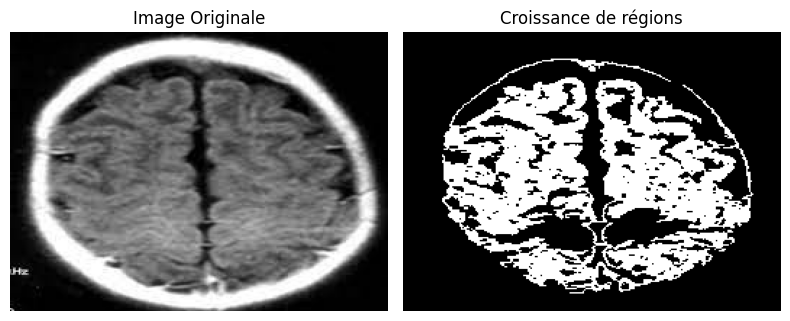

In [98]:
from skimage import io, color
from skimage.segmentation import flood

# Charger l'image
image = io.imread(r'1.jpeg')
image_gray = color.rgb2gray(image)

# Point de départ pour la croissance de région
seed_point = (100, 100)  # à ajuster selon l'image
segmented_image = flood(image_gray, seed_point, tolerance=0.1)

# Affichage
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR à RGB pour l'affichage
plt.axis('off')  # Désactiver les axes

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Croissance de régions")
plt.axis('off')
plt.tight_layout()
plt.show()

## Mesure de performance par rapport à la vérité de terrain

In [102]:
def performance_metrics(prediction, ground_truth):
    # Assurez-vous que les images sont binaires (0 ou 1)
    prediction = prediction.astype(np.uint8)
    ground_truth = ground_truth.astype(np.uint8)

    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)

    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    dice = 2 * np.sum(intersection) / (np.sum(prediction) + np.sum(ground_truth)) if (np.sum(prediction) + np.sum(ground_truth)) != 0 else 0

    return iou, dice
# Charger la vérité de terrain
ground_truth = cv2.imread(r'masked_1.jpg', cv2.IMREAD_GRAYSCALE)
_, ground_truth_binary = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)  # Assurez-vous que c'est binaire


# Calculer les métriques de performance
iou, dice = performance_metrics(segmented_image, ground_truth_binary)

# Afficher les résultats des métriques
print(f"Croissance de Régions - IoU: {iou:.4f}, Dice: {dice:.4f}")

Croissance de Régions - IoU: 0.5091, Dice: 0.0040


# Méthode 4 : Watershed

## Version from scratch

In [79]:
def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Mark unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Mark the connected components
    markers = cv2.connectedComponents(np.uint8(sure_fg))[1]
    markers = markers + 1  # Increment marker for sure_fg
    markers[unknown == 255] = 0  # Mark unknown as zero

    # Apply watershed
    cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark the borders in red

    return image

## Version importée

Image shape: (873, 1920)
Markers shape: (873, 1920)
Distance shape: (873, 1920)
Mask shape: (873, 1920)


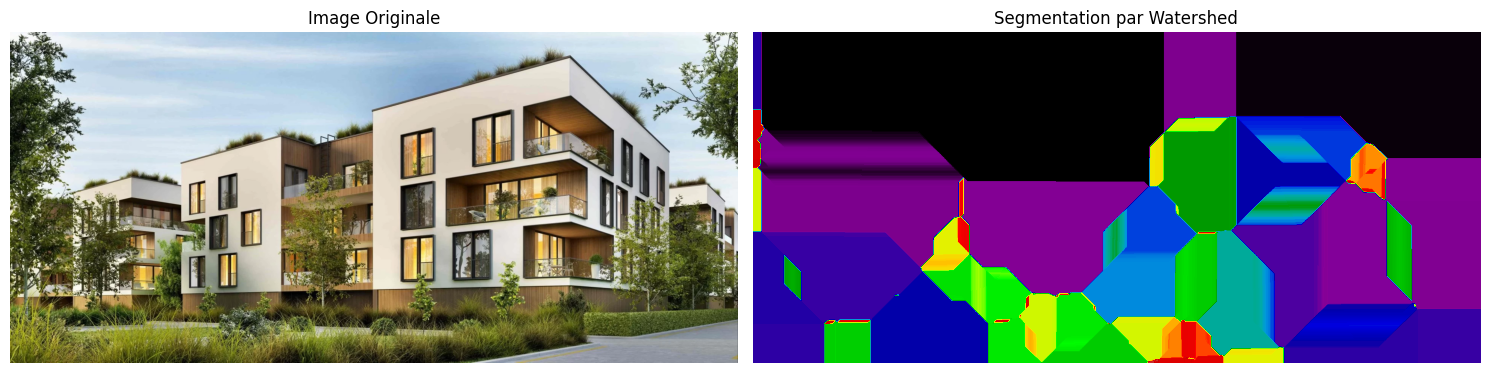

In [35]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

image_gray = color.rgb2gray(image)  # Convertir l'image en niveaux de gris

#  Appliquer la transformation de distance
distance = ndimage.distance_transform_edt(image_gray)

# Trouver les maxima locaux
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image_gray > 0)

# Marquage des maxima locaux
markers = np.zeros_like(image_gray, dtype=int)  # Remplacez np.int par int
markers[tuple(local_maxi.T)] = np.arange(1, len(local_maxi) + 1)  # Marquer les maxima locaux avec des valeurs uniques

# Imprimer les formes de l'image et des marqueurs
print(f'Image shape: {image_gray.shape}')
print(f'Markers shape: {markers.shape}')
print(f'Distance shape: {distance.shape}')
mask = image_gray > 0
print(f'Mask shape: {mask.shape}')

# Application de la méthode de segmentation Watershed
labels = watershed(-distance, markers, mask=mask)

# Affichage
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR à RGB pour l'affichage
plt.axis('off')  # Désactiver les axes

plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Segmentation par Watershed")
plt.axis('off')
plt.tight_layout()
plt.show()

# Méthode 5 : K-means Clustering

## Version from scratch

In [58]:
# Charger l'image
image_path = r'1.jpeg'
image = cv2.imread(image_path)

In [103]:
def kmeans_segmentation(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    _, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8 bit values
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

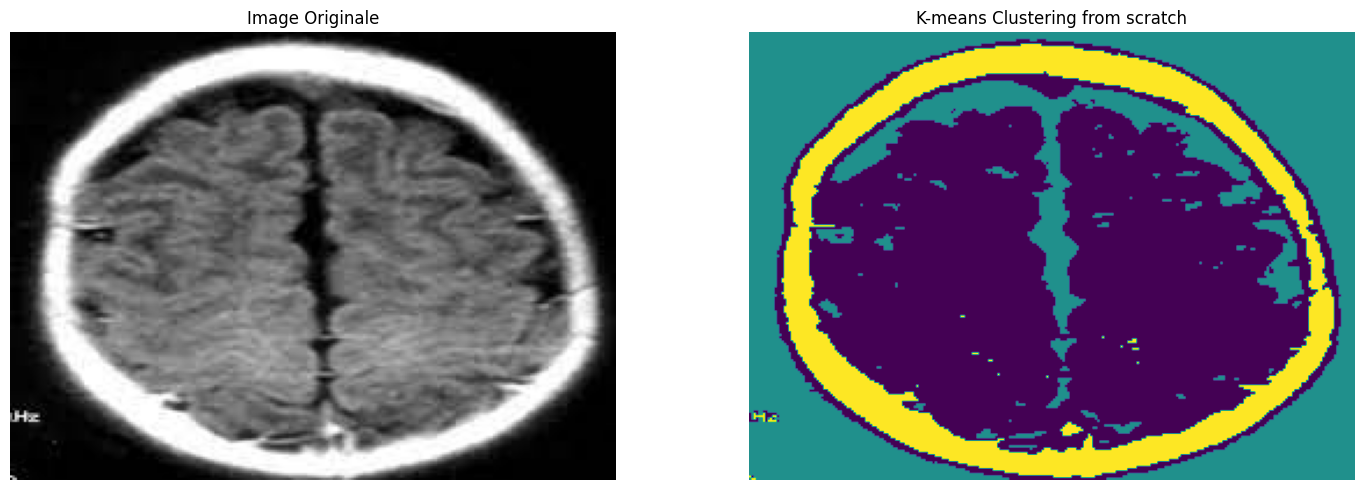

In [51]:
# Affichage
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR à RGB pour l'affichage
plt.axis('off')  # Désactiver les axes

plt.subplot(1, 2, 2)
plt.title("K-means Clustering from scratch")
plt.imshow(segmented_image)
plt.axis('off')
plt.tight_layout()
plt.show()

## Version importée

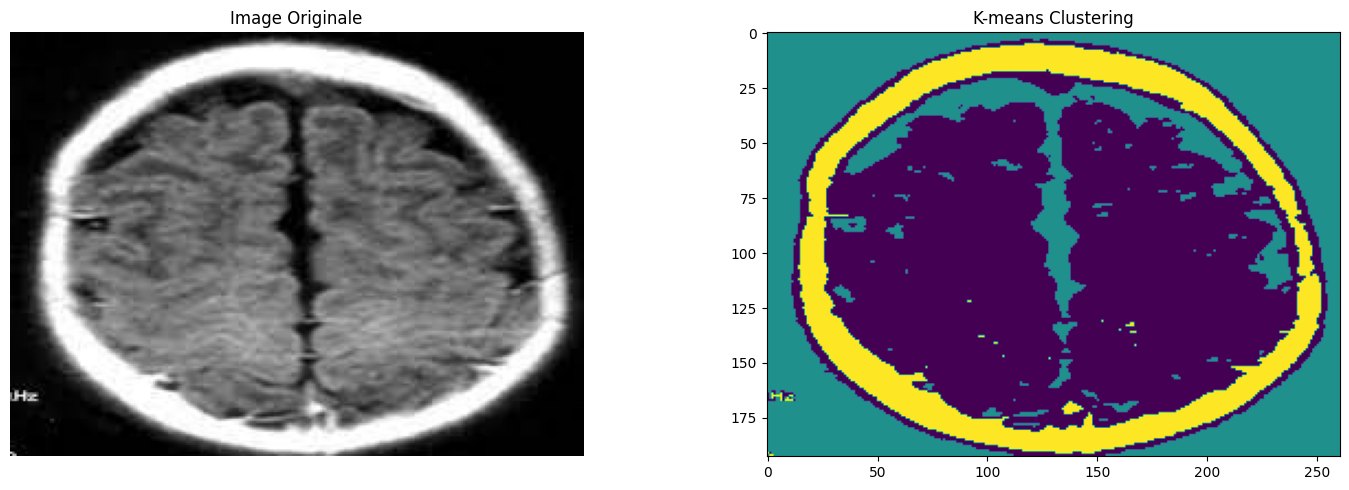

In [104]:
from sklearn.cluster import KMeans

# Conversion de l'image en un tableau 2D pour K-means
image_2d = image.reshape((-1, 3))
kmeans = KMeans(n_clusters=3, random_state=0).fit(image_2d)
segmented_image = kmeans.labels_.reshape(image.shape[:2])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR à RGB pour l'affichage
plt.axis('off')  # Désactiver les axes

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='viridis')
plt.title("K-means Clustering")
plt.tight_layout()
plt.show()

## Mesure de performance

In [105]:
# Charger la vérité de terrain
ground_truth = cv2.imread(r'masked_1.jpg', cv2.IMREAD_GRAYSCALE)
_, ground_truth_binary = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)  # Assurez-vous que c'est binaire


# Calculer les métriques de performance
iou, dice = performance_metrics(segmented_image, ground_truth_binary)

# Afficher les résultats des métriques
print(f"Croissance de Régions - IoU: {iou:.4f}, Dice: {dice:.4f}")

Croissance de Régions - IoU: 0.1529, Dice: 0.0019


# Méthode 6 : Segmentation par Contours Actifs (Snakes)

## Version from scratch

In [71]:
def active_contours(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initial snake
    s = np.linspace(0, 2*np.pi, 400)
    x = 100 + 100*np.cos(s)  # Initial circle
    y = 100 + 100*np.sin(s)
    init = np.array([x, y]).T

    # Apply active contour
    snake = measure.find_contours(gray, 0.8)
    
    return snake

In [ ]:
image=cv2.imread(r'contour.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
s = np.linspace(0, 2*np.pi, 400)
x = 100 + 50 * np.cos(s)
y = 100 + 50 * np.sin(s)
init = np.array([x, y]).T


# Affichage
plt.imshow(image_gray, cmap='gray')
plt.plot(init[:, 0], init[:, 1], '--r', label='Contour initial')
plt.plot(snake[:, 0], snake[:, 1], '-b', label='Contour final')
plt.legend()
plt.title("Segmentation par contours actifs")
plt.show()

## Version importée

In [ ]:
from skimage.segmentation import active_contour

image=cv2.imread(r'contour.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
s = np.linspace(0, 2*np.pi, 400)
x = 100 + 50 * np.cos(s)
y = 100 + 50 * np.sin(s)
init = np.array([x, y]).T

# Appliquer la segmentation par contours actifs
snake = active_contour(image_gray, init, alpha=0.015, beta=10, gamma=0.001)

# Affichage
plt.imshow(image_gray, cmap='gray')
plt.plot(init[:, 0], init[:, 1], '--r', label='Contour initial')
plt.plot(snake[:, 0], snake[:, 1], '-b', label='Contour final')
plt.legend()
plt.title("Segmentation par contours actifs")
plt.show()

# Exécution et Analyse Comparative

# Creation des masques binaires appliqués aux images utilisées (la vérité de terrain)

In [86]:
import cv2
import numpy as np
import os

def create_binary_mask(image):
    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Appliquer un flou pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Appliquer une détection de contours
    edges = cv2.Canny(blurred, 100, 200)
    
    # Créer un masque binaire
    mask_generated = np.zeros_like(image[:, :, 0])  # Masque avec la même hauteur et largeur que l'image d'origine
    mask_generated[edges > 0] = 1  # Assigner 1 aux pixels où il y a des contours
    
    return mask_generated

def draw_mask(image, mask_generated):
    masked_image = image.copy()
    
    # Convertir mask_generated en une image en 3 canaux pour qu'il corresponde à l'image d'origine
    mask_colored = np.zeros_like(image)  # Créer une image vide avec les mêmes dimensions que l'image d'origine
    mask_colored[mask_generated > 0] = [0, 255, 0]  # Remplir avec la couleur verte là où le masque est actif

    # Appliquer le masque à l'image d'origine
    masked_image = cv2.addWeighted(image, 0.3, mask_colored, 0.7, 0)

    return masked_image

# Vérifier si l'image a été chargée correctement
if image is None:
    print("Erreur : l'image n'a pas pu être chargée. Vérifiez le chemin d'accès.")
else:
    # Créer le masque
    mask_generated = create_binary_mask(image)

    # Appliquer le masque à l'image
    result_image = draw_mask(image, mask_generated)

    # Définir le chemin pour enregistrer l'image masquée
    save_path = os.path.join(os.path.dirname(image_path), 'masked_image.jpg')
    
    # Enregistrer l'image résultante
    cv2.imwrite(save_path, result_image)
    print(f"L'image masquée a été enregistrée sous : {save_path}")

L'image masquée a été enregistrée sous : masked_image.jpg


In [ ]:
image=cv2.imread(r'1.jpeg')
if image is None:
    print("Erreur : l'image n'a pas pu être chargée. Vérifiez le chemin d'accès.")
else:
    # Créer le masque
    mask_1 = create_binary_mask(image)

    # Appliquer le masque à l'image
    result_image = draw_mask(image, 1)

    # Définir le chemin pour enregistrer l'image masquée
    save_path = os.path.join(os.path.dirname(image_path), 'masked_1.jpg')
    
    # Enregistrer l'image résultante
    cv2.imwrite(save_path, result_image)
    print(f"L'image masquée a été enregistrée sous : {save_path}")

L'image masquée a été enregistrée sous : masked_1.jpg


In [92]:
image=cv2.imread(r'2.jpg')
if image is None:
    print("Erreur : l'image n'a pas pu être chargée. Vérifiez le chemin d'accès.")
else:
    # Créer le masque
    mask_1 = create_binary_mask(image)

    # Appliquer le masque à l'image
    result_image = draw_mask(image, 1)

    # Définir le chemin pour enregistrer l'image masquée
    save_path = os.path.join(os.path.dirname(image_path), 'masked_2.jpg')
    
    # Enregistrer l'image résultante
    cv2.imwrite(save_path, result_image)
    print(f"L'image masquée a été enregistrée sous : {save_path}")

L'image masquée a été enregistrée sous : masked_2.jpg


In [87]:
cv2.imread(r'masked_image.jpg')

array([[[ 75,  76,  74],
        [ 75,  76,  74],
        [ 75,  76,  74],
        ...,
        [ 22,  30,  30],
        [ 28,  35,  32],
        [ 67,  74,  67]],

       [[ 75,  76,  74],
        [ 75,  76,  74],
        [ 75,  76,  74],
        ...,
        [ 36,  65,  42],
        [ 25,  52,  26],
        [ 36,  61,  33]],

       [[ 75,  76,  74],
        [ 75,  76,  74],
        [ 75,  76,  74],
        ...,
        [139, 214, 140],
        [123, 191, 120],
        [116, 179, 109]],

       ...,

       [[ 85, 195, 106],
        [ 75, 170,  96],
        [  0,  34,   0],
        ...,
        [ 45,  43,  42],
        [ 44,  42,  41],
        [ 33,  31,  30]],

       [[  0,  75,   0],
        [  0,  45,   0],
        [  0,  30,  12],
        ...,
        [ 47,  45,  44],
        [ 45,  43,  42],
        [ 34,  32,  31]],

       [[  0,  45,  17],
        [  0,  30,   7],
        [  0,  29,  20],
        ...,
        [ 51,  47,  46],
        [ 49,  45,  44],
        [ 38,  34,  33]]